In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

안녕하세요, 멘토님.

오늘은 상관분석(Pearson correlation analysis) 혹은 회귀분석(linear regression analysis)에 관한 질문을 준비해보았습니다.
먼저 아래는 이번 프로젝트의 전체적인 방향성에 대하여 그림을 그려본 것인데요.
이 중에서 `feature analysis (Pearson correlation analysis, regression analysis)` 에 해당하는 부분입니다.

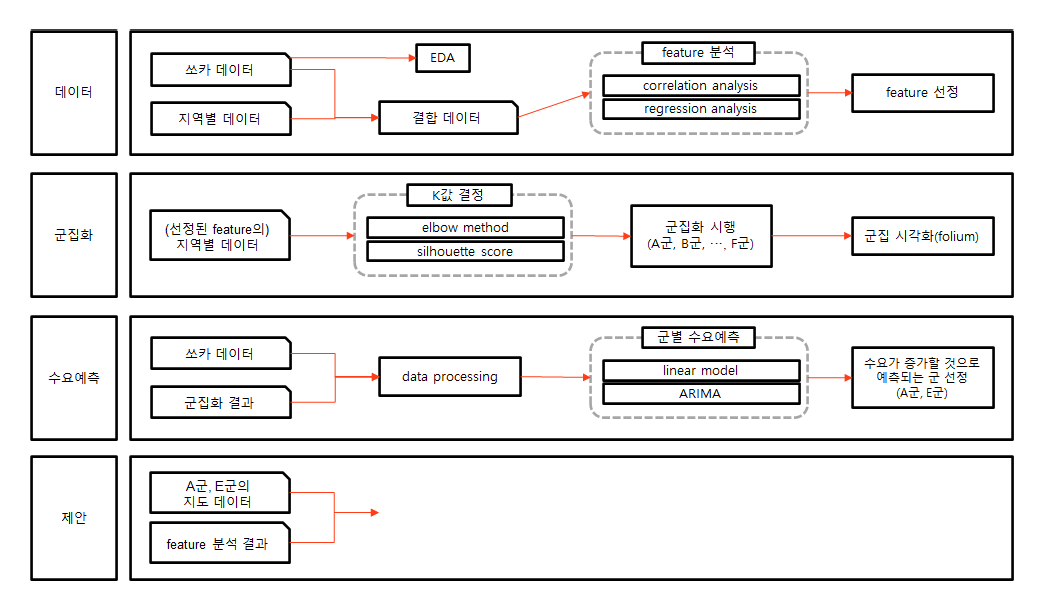

전체적인 계획이 그림에 잘 표현되어 있다고 생각하지만, 다시 한번 부연해 말씀드리면 다음과 같습니다.
먼저, 각 지역별로 여러 종류의 데이터들을 모았습니다.
그렇게 얻은 feature들 중 `이용 수`와 관련이 있는 것으로 판단되는 feature들을 선별하는 과정이 이 과정입니다.
이후에, 선별한 feature들만 가지고 군집화를 진행하게 됩니다.
또한, 나중에 쏘카존 위치를 제안하는 등의 최종적인 결론을 낼 때에도 이 feature 분석 지표들을 사용하게 됩니다.

한편, 아래 코드들은, 이번 프로젝트에서 시행한 상관분석과 회귀분석 과정입니다.
당연히, 모든 내용들을 보실 필요는 없을 것 같습니다.
다만, `intersected`라는 `DataFrame`이 상관분석과 회귀분석에 사용할 데이터셋임을 숙지해주시면 좋을 것 같습니다.

In [3]:
collected_data = pd.read_csv('../../data/data_c_final/2c201_1230_collected_data.csv')
collected_data.set_index("지역", inplace=True)
collected_data.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구
지역,,,,,,,,,,,,,,,,
수원시 장안구,37.303971,127.001743,18,0.272727,0.727273,0.000000,0.000000,271012,4,200,1,409,0,0,34441,82294.55980
수원시 권선구,37.257687,126.963532,16,0.625000,0.312500,0.062500,0.000000,367004,1,159,4,537,0,1,11033,111443.15610
수원시 팔달구,37.282570,127.011718,20,0.136364,0.409091,0.000000,0.454545,192225,0,65,4,185,2,1,0,58370.37385
수원시 영통구,37.259600,127.042341,34,0.142857,0.571429,0.285714,0.000000,360127,21,129,6,380,0,3,22911,109354.91020
용인시 처인구,37.234346,127.192965,29,0.823529,0.058824,0.000000,0.117647,259872,15,112,9,1234,0,1,13084,67270.69540


In [4]:
# collected_data.sort_values(by='지역',inplace=True)
# collected_data['dumb'] = np.arange(len(collected_data))
# collected_data

In [5]:
hackathon_data_original = pd.read_csv("../../data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [6]:
hackathon_data = pd.DataFrame(hackathon_data_original['region2'].value_counts())
hackathon_data.reset_index(inplace=True)
hackathon_data['index'].replace({ 
    '수원시\u3000팔달구':'수원시 팔달구', '수원시\u3000영통구':'수원시 영통구', '용인시\u3000기흥구':'용인시 기흥구',
    '고양시\u3000일산동구':'고양시 일산동구', '안양시\u3000동안구':'안양시 동안구', '고양시\u3000일산서구':'고양시 일산서구',
    '성남시\u3000수정구':'성남시 수정구', '수원시\u3000장안구':'수원시 장안구', '성남시\u3000중원구':'성남시 중원구',
    '안산시\u3000단원구':'안산시 단원구', '용인시\u3000수지구':'용인시 수지구', '고양시\u3000덕양구':'고양시 덕양구',
    '용인시\u3000처인구':'용인시 처인구', '안양시\u3000만안구':'안양시 만안구', '성남시\u3000분당구':'성남시 분당구',
    '수원시\u3000권선구':'수원시 권선구', '안산시\u3000상록구':'안산시 상록구',}, inplace=True)
hackathon_data.columns = ['지역', '이용 수']
hackathon_data.set_index('지역', inplace=True)
hackathon_data.head()

,이용 수
지역,
성남시 분당구,46782
화성시,35249
고양시 일산동구,31906
남양주시,26546
고양시 덕양구,26253


In [7]:
intersected_rows = set.intersection(set(collected_data.index), set(hackathon_data.index))
intersected_rows = list(intersected_rows)
print(len(intersected_rows),'개 지역 \n',intersected_rows)

16 개 지역 
 ['김포시', '성남시 수정구', '하남시', '양평군', '남양주시', '광명시', '성남시 중원구', '안양시 동안구', '고양시 일산서구', '고양시 덕양구', '안양시 만안구', '구리시', '고양시 일산동구', '성남시 분당구', '화성시', '의정부시']


In [8]:
collected_data_intersected = collected_data[collected_data.index.isin(intersected_rows)]
collected_data_intersected.sort_index(ascending=True, inplace=True)
hackathon_data_intersected = hackathon_data[hackathon_data.index.isin(intersected_rows)]
hackathon_data_intersected.sort_index(ascending=True, inplace=True)
intersected = pd.concat([collected_data_intersected, hackathon_data_intersected],axis=1)
intersected['쏘카존 수 대비 이용 수'] = intersected['이용 수']/intersected['쏘카존 수']
intersected

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구,이용 수,쏘카존 수 대비 이용 수
지역,,,,,,,,,,,,,,,,,,
고양시 덕양구,37.637431,126.823745,48,0.656250,0.343750,0.000000,0.000000,487874,6,274,9,1205,2,8,4210,131281.05900,26253,546.937500
고양시 일산동구,37.658622,126.771006,51,0.461538,0.461538,0.000000,0.076923,296590,1,133,6,454,0,0,13923,79808.82212,31906,625.607843
고양시 일산서구,37.677991,126.741105,29,0.500000,0.375000,0.000000,0.125000,290738,0,140,4,635,0,0,0,78234.11890,16052,553.517241
광명시,37.478618,126.856271,28,0.222222,0.666667,0.000000,0.111111,288182,0,89,3,445,0,0,0,76757.00000,22645,808.750000
구리시,37.594266,127.121253,19,0.500000,0.500000,0.000000,0.000000,188876,0,111,2,313,0,1,0,51033.00000,13011,684.789474
김포시,37.615350,126.707165,55,0.400000,0.533333,0.066667,0.000000,484194,3,229,9,1325,0,7,232,127499.00000,21500,390.909091
남양주시,37.635985,127.212283,57,0.526316,0.473684,0.000000,0.000000,737366,2,385,13,1803,0,6,8100,176762.00000,26546,465.719298
성남시 분당구,37.382819,127.110546,58,0.500000,0.500000,0.000000,0.000000,482026,1,231,12,694,3,0,0,137576.86410,46782,806.586207
성남시 수정구,37.450396,127.137254,18,0.631579,0.368421,0.000000,0.000000,232125,11,91,9,436,2,5,20021,66251.67434,18773,1042.944444


## 상관분석 (pearson correlation analysis)

In [9]:
pearson = intersected.corr()[['이용 수', '쏘카존 수 대비 이용 수']]
pearson['abs value'] = abs(pearson['이용 수'])
pearson.sort_values(by='abs value', ascending=False, inplace=True)
pearson.drop(columns = ['abs value'], inplace=True)
pearson.drop(index = ['이용 수', '쏘카존 수 대비 이용 수'], inplace=True)
pearson

,이용 수,쏘카존 수 대비 이용 수
쏘카존 수,0.806230,-0.537069
2030인구,0.686101,-0.334138
인구,0.649762,-0.390717
환승역 수,0.637355,0.078405
아파트 수,0.623385,-0.388349
경도,-0.393671,0.128923
주거,0.381949,0.060353
녹지,-0.369392,-0.148646
정류장 수,0.335510,-0.491441
지하철역 수,0.286200,-0.312177


위 셀은 상관분석의 결과입니다.
이전에도 몇 번 보여드렸던 결과이기도 합니다.
`이용 수`와 여러 feature들 사이의 pearson correlation을 나타냅니다.
예를 들어, `쏘카존 수`는 `이용 수`와 높은 양의 상관관계를 가지고 있습니다. (0.806230)

이것은 `intersected`의 두 열을 살펴보고 (아래 셀)

In [10]:
intersected[['쏘카존 수', '이용 수']]

,쏘카존 수,이용 수
지역,,
고양시 덕양구,48,26253
고양시 일산동구,51,31906
고양시 일산서구,29,16052
광명시,28,22645
구리시,19,13011
김포시,55,21500
남양주시,57,26546
성남시 분당구,58,46782
성남시 수정구,18,18773


두 열을 scatter plot 해보면

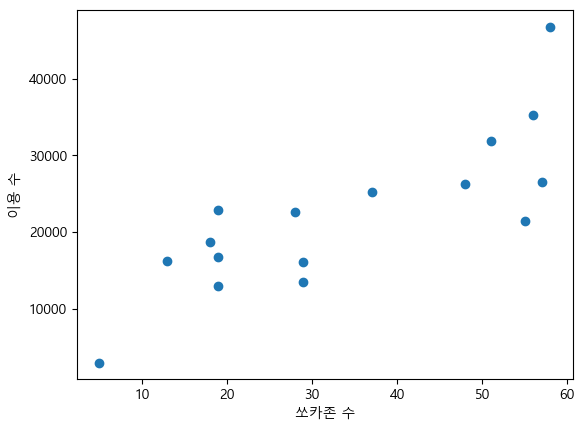

In [11]:
plt.xlabel('쏘카존 수')
plt.ylabel('이용 수')
plt.scatter(intersected['쏘카존 수'], intersected['이용 수'])
plt.show()

정말로, 양의 상관관계가 보이는 것을 확인할 수 있습니다.
조금 더 정확히 말하면, pearson correlation은 두 변수 사이의 공분산(correlation)을 각 변수의 표준편차의 곱으로 나눈 것
$$\rho_{X,Y} = \frac{\text{cov(X,Y)}}{\sigma_X\sigma_Y}=\frac{\mathbb E\left[(X-\mu_X)(Y-\mu_Y)\right]}{\sigma_X\sigma_Y}$$
으로서, 두 변수가 얼마나 *선형적으로* 관련있는지를 나타내는 값이므로, 위의 결과를 '두 변수가 완전히 일직선을 이루는 것은 당연히 아니지만, 그래도 어느 정도는 직선의 형태로 표현된다'라고 판단할 수 있을 것 같습니다.

반면, `대학교 수`의 경우 `이용 수`와 큰 상관관계 값을 나타내고 있지 않습니다(0.153327).
아까와 마찬가지로 해보면

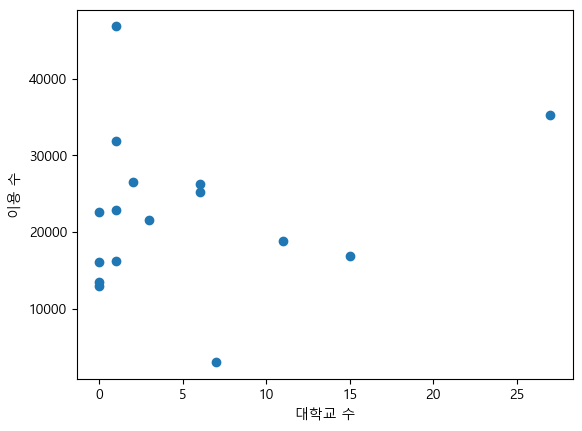

In [12]:
plt.xlabel('대학교 수')
plt.ylabel('이용 수')
plt.scatter(intersected['대학교 수'], intersected['이용 수'])
plt.show()

두 변수는 별 관계가 없는 것이 그래프로도 확인됩니다.

<!-- 한편, 위에 적은 식을 보더라도, Pearson correlation ceofficient는 순수하게 두 변수 사이의 관계만 나타내는 지표입니다.
다시 말해서, 다른 feature들이 어떤 값을 가지고 있건 상관없이 결정되는 값입니다. -->

## 회귀분석 (linear regression analysis)

이번에는 회귀분석을 통해 `이용 수`에 영향을 미치는 feature가 어떤 것이 있는지 살펴보려 했습니다.
여기서 말하는 회귀분석(regression analysis)란, 단순히 선형회귀분석(linear regression analysis)를 의미합니다.
독립변수가 여러 개이므로 다중선형회귀분석(multivariate linear regression analysis)라고 해도 될 것 같습니다.

In [13]:
intersected.columns

Index(['위도', '경도', '쏘카존 수', '녹지', '주거', '공업', '상업', '인구', '대학교 수', '아파트 수',
       '지하철역 수', '정류장 수', '환승역 수', '행복주택 수', '대학생 수', '2030인구', '이용 수',
       '쏘카존 수 대비 이용 수'],
      dtype='object')

`intersected`는 18개의 column(features)과 16개의 row(지역)으로 이루어져있습니다.
이 중 `이용 수`는 종속변수 $y$에 해당하고, `쏘카존 수 대비 이용 수`는 `이용 수`와 `쏘카존 수`를 나눠서 얻은 값이므로, 이 둘을 제외하면 총 16개의 독립변수($X_1,X_2,\cdots,X_{16}$)가 존재하게 됩니다.

회귀분석의 목적은 $y$를 $X_i$들의 선형적인 식을 통해 표현하는 것입니다.
다시 말해,
$$y = b_0+b_1X_1+\cdots+b_{16}X_{16}$$
인 선형모델을 생각하고 이 선형모델 중 (MSE 관점에서) 가장 $y$를 잘 표현하는 모델
$$\hat y = \hat{b_0}+\hat{b_1}X_1+\cdots+\hat{b_{16}}X_{16}$$
을 선정하는 것입니다.
그렇게 얻은 계수(coefficient)들 $b_i$들을 비교해봤을 때, "계수($\hat{b_i}$)의 절댓값이 클수록 $X_i$는 $y$에 많은 영향을 끼친다"라는 결론을 얻으려고 합니다.

(*혹시 이 설명에서 틀리거나 개선해야 할 부분이 있다면 말씀해주시면 감사하겠습니다.*)

아래 코드에서는 두 패키지 `sklearn`과 `statsmodels`를 사용하여 각각 회귀분석을 진행해봤습니다.

### sklearn

In [14]:
independents = intersected.copy()
independents = independents.drop(["이용 수", "쏘카존 수 대비 이용 수"], axis=1)
dependent = intersected["이용 수"]
independents.shape, dependent.shape

((16, 16), (16,))

In [15]:
# R squared의 값은 1에 가깝게 나온다. 독립변수들(feature들)을 하나나 두 개라도 줄이면 R squared의 값은 0.99xxx로 나타난다.
reg = LinearRegression().fit(independents, dependent)
print("R squared :",reg.score(independents, dependent))

R squared : 1.0


In [16]:
result = pd.DataFrame({'features':independents.columns, "coefficients":reg.coef_})
result['abs value'] = abs(result['coefficients'])
result.sort_values(by='abs value', ascending=False, inplace=True)
result.drop(columns = ['abs value'], inplace=True)
result

,features,coefficients
6,상업,95413.249067
0,위도,-58292.804648
5,공업,-50648.668937
3,녹지,-34221.769805
1,경도,16355.045849
4,주거,-10542.810325
12,환승역 수,2753.693659
2,쏘카존 수,826.879031
8,대학교 수,-232.376012
13,행복주택 수,218.997813


위의 표는 그 결과입니다.
이 결과를 토대로 본다면, `이용 수`에 가장 많은 영향을 미치는 feature들은 `상업`, `위도`, `공업`, `녹지` 등입니다.
이것은 위에서 수행한 '상관관계 분석'의 결과와 상당히 다른 것 같습니다.

이번에는 똑같은 과정을 `sklearn`을 사용하지 않고 `statsmodels`를 사용하여 해보았습니다.

In [17]:
import statsmodels.api as sm
#define response variable
y = dependent
#define predictor variables
x = independents
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                nan
Time:                        17:59:57   Log-Likelihood:                 172.15
No. Observations:                  16   AIC:                            -312.3
Df Residuals:                       0   BIC:                            -299.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.095e+05        inf          0        n

In [18]:
result = pd.DataFrame(model.params, columns=['coefficients'])
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,coefficients
상업,122793.570870
const,109521.287233
위도,-58292.804573
공업,-23268.346844
주거,16837.511683
경도,16355.045817
녹지,-6841.447763
환승역 수,2753.693653
쏘카존 수,826.879030
대학교 수,-232.376012


그 결과는 `sklearn`을 사용했을때와 거의 같습니다.
`상업`, `위도`, `공업`, `녹지`가 큰값의 계수를 가지고 있고, 다만 `const`라는 값이 새로 생겼습니다. (아마도 y절편 값인 듯합니다.)

*질문입니다.* 이 결과를 어떻게 해석해야 할까요? (1) *상관분석의 계수가 낮게 나타나더라도, 회귀분석의 계수가 높게 나올 수 있나요?* 혹은 (2) *위의 회귀분석 방법이 혹시 잘못되었을까요?*

(2)에 대한 해답으로, 두 가지 정도를 생각해보았습니다.
- (2-1) 독립변수들의 스케일 조정이 필요하다 (e.g. min-max scaling)
- (2-2) 다중공산성(multicolinearity) 가정이 깨졌다.

## (2-1) 독립변수들의 스케일 조정이 필요하다 (e.g. min-max scaling)

`sklearn`의 문서 [Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)를 읽어보니, scaling을 적절히 하는 게 중요하다고 되어 있는 것 같았습니다.
그래서, 독립변수에 대하여 min-max scaling과 같은 스케일 조정이 필요하다고 판단했습니다.

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
independents_scaled = scaler.fit_transform(independents.to_numpy())
independents_scaled = pd.DataFrame(independents_scaled, columns=independents.columns, index=independents.index)
independents_scaled.head()

,위도,경도,쏘카존 수,녹지,주거,공업,상업,인구,대학교 수,아파트 수,지하철역 수,정류장 수,환승역 수,행복주택 수,대학생 수,2030인구
지역,,,,,,,,,,,,,,,,
고양시 덕양구,0.813094,0.151001,0.811321,0.558036,0.458333,0.0,0.000000,0.465198,0.222222,0.673352,0.40,0.363844,0.666667,0.470588,0.210279,0.460164
고양시 일산동구,0.852445,0.082691,0.867925,0.307692,0.615385,0.0,0.615385,0.221678,0.037037,0.269341,0.25,0.077422,0.000000,0.000000,0.695420,0.244822
고양시 일산서구,0.888413,0.043961,0.452830,0.357143,0.500000,0.0,1.000000,0.214228,0.000000,0.289398,0.15,0.146453,0.000000,0.000000,0.000000,0.238234
광명시,0.518186,0.193130,0.433962,0.000000,0.888889,0.0,0.888889,0.210974,0.000000,0.143266,0.10,0.073989,0.000000,0.000000,0.000000,0.232054
구리시,0.732939,0.536347,0.264151,0.357143,0.666667,0.0,0.000000,0.084549,0.000000,0.206304,0.05,0.023646,0.000000,0.058824,0.000000,0.124434


In [20]:
reg = LinearRegression().fit(independents_scaled, dependent)
print("R squared :",reg.score(independents_scaled, dependent))

R squared : 1.0


In [21]:
result = pd.DataFrame({'features':independents.columns, "coefficients":reg.coef_})
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,features,coefficients
7,인구,-133113.553726
9,아파트 수,66557.021504
2,쏘카존 수,43824.588622
0,위도,-31391.724573
11,정류장 수,25174.597670
6,상업,14621.011197
15,2030인구,13166.869651
1,경도,12626.960576
3,녹지,-9852.056115
12,환승역 수,8261.080976


어떤 의미에서는 아까보다 나은 결과이기는 하지만, 여전히 이해할 수 없는 결과가 나왔습니다.
이 결과를 "`인구`가 높아질수록 `이용 수`가 감소한다"라고 해석해야 할 것 같은데, 이것은 직관과도, 그리고 상관관게 분석의 결과와도 일치하지 않고 있습니다.

이번에는 `statsmodels`를 통해 똑같은 작업을 수행해보았습니다.

In [22]:
import statsmodels.api as sm
#define response variable
y = dependent
#define predictor variables
x = independents_scaled
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 Jan 2023   Prob (F-statistic):                nan
Time:                        17:59:57   Log-Likelihood:                 366.26
No. Observations:                  16   AIC:                            -700.5
Df Residuals:                       0   BIC:                            -688.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7145.1859        inf          0        n

In [23]:
result = pd.DataFrame(model.params, columns=['coefficients'])
result['abs coef.'] = abs(result['coefficients'])
result.sort_values(by='abs coef.', ascending=False, inplace=True)
result.drop(columns = ['abs coef.'], inplace=True)
result

,coefficients
인구,-133113.553726
아파트 수,66557.021504
쏘카존 수,43824.588622
위도,-31391.724573
정류장 수,25174.597670
상업,15202.126846
2030인구,13166.869651
경도,12626.960576
주거,11745.716536
환승역 수,8261.080976


`sklearn`으로 작업한 것과 같은 결과가 나왔습니다.

### (2-2) 다중공산성(multicolinearity) 가정이 깨졌다.

[이 블로그](https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html)에 따르면, 선형회귀를 하기 위해서는 다중공산성 가정이 있어야 한다고 합니다.

다시 말해, 만약 독립변수들 간의 상관관계가 존재한다면, 제대로 된 linear regression이 수행되지 않는다는 것입니다.
첫번째 `statsmodels` 결과를 보더라도 "The condition number is large, 1.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems."와 같은 말이 쓰여져 있습니다.

위의 글에서 이러한 다중공산성 이슈를 해결하기 위해서는 VIF를 쓸 수 있다고 되어 있습니다.
각 독립변수(feature)에 대하여 VIF(Variance Inflation Factors)란, 해당 독립변수가 자신 외의 다른 독립변수로 얼마나 설명될 수 있는지를 나타내는 지표인 것 같습니다.
VIF의 방법을 사용하여, 이 문제를 해결해보려고 했습니다. (아래 코드)

In [24]:
independents.shape, dependent.shape

((16, 16), (16,))

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    independents.values, i) for i in range(independents.shape[1])]
vif["features"] = independents.columns
vif.sort_values(by='VIF Factor', ascending=True)


,VIF Factor,features
14,3.298231e+00,대학생 수
12,7.327975e+00,환승역 수
10,7.510271e+00,지하철역 수
1,1.508439e+01,경도
8,4.229706e+01,대학교 수
11,5.489970e+01,정류장 수
2,5.820572e+01,쏘카존 수
0,6.024506e+01,위도
13,6.318643e+01,행복주택 수
9,2.640857e+02,아파트 수


In [26]:
# 녹지, 주거, 공업, 상업의 vif값이 굉장히 커보인다. 이 feature들을 제거한다.
y = dependent
x = independents.drop(['녹지', '주거', '공업', '상업'],axis=1)
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     13.54
Date:                Mon, 30 Jan 2023   Prob (F-statistic):             0.0271
Time:                        17:59:58   Log-Likelihood:                -137.78
No. Observations:                  16   AIC:                             301.6
Df Residuals:                       3   BIC:                             311.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.276e+05   1.32e+06      0.477      0.6

VIF 값이 높은 feature들을 제거했는데도 불구하고, 여전히 multicolinearity 이슈가 발생합니다.
여기에서 더 feature들을 제거하려면, `인구`, `아파트 수` 등을 제거해야 하는데, 이것은 중요한 feature로서 `인구`와 `아파트 수`를 상정하고 있는 상황이기에 이것들을 제거하기가 주저됩니다.

긴 글 읽어주셔서 감사합니다.
여하튼, 선형회귀분석을 통해 `이용 수`와 관련있는 feature들이 어떤 것이 있을지를 확인해보는 과정이었습니다.
현재로서는 선형회귀분석의 방법을 통해서는 의미있는 결과가 나오는 것 같지 않습니다.

요약하면 질문은 다음과 같습니다.
(1) 이 방향으로 가는 것이 맞는지, 그리고 (2-1) 선형회귀분석에서 scaling이 필요한지, (2-2) 다중공산성 이슈를 해결하기 위해서 위와 같이 하는 게 맞는 지 질문드립니다.